In [1]:
# dataset = cifar10
# model = mobilenet
# optimizer = ADAM (0.001)
# loss = categorical_crossentropy
# batch_size = 32
# decay = l2 (0.01)
# augmentation = off
# validation_split = 0.2

In [2]:
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Input, Flatten, AveragePooling2D, Add
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
# https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import L2

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist

In [3]:
batch_size=64
epochs=100
num_classes=10 
depth=20 

In [4]:
model_type = 'MobileNet%d' % (depth)

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train/255
x_test = x_test/255

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
input_shape=x_train.shape[1:]

170500096/170498071 [==============================] - 4s 0us/step


In [6]:
#datagen = ImageDataGenerator(rotation_range=40, horizontal_flip=True, zoom_range=0.1, width_shift_range=0.05, height_shift_range=0.05)
#augmented_data = datagen.flow(x_train[:40000], y_train[:40000])

In [7]:
def mobilenet(input_size, l2_decay, N_CLASSES):
    """
    Builds the MobileNet model.
    :param tuple input_size: The height and width (in that order) of the
        model input.
    :param float l2_decay: The amount of L2 weight decay to add to the
        loss. Applies only to kernels, not biases.
    :return tensorflow.keras.Sequential: A MobileNet model.
    """

    model = Sequential()

    def _add_bn_relu():
        model.add(BatchNormalization(scale=False))
        model.add(ReLU())

    def _add_depthwise_block(strides=1):
        model.add(DepthwiseConv2D(
            (3, 3),
            strides=strides,
            padding='same',
            kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    def _add_pointwise_block(filters):
        model.add(Conv2D(filters, (1, 1), kernel_regularizer=L2(l2=l2_decay)))
        _add_bn_relu()

    model.add(Conv2D(
        32, (3, 3),
        strides=2,
        padding='same',
        kernel_regularizer=L2(l2=l2_decay),
        input_shape=input_size + (3,)))
    _add_bn_relu()
    _add_depthwise_block()
    _add_pointwise_block(64)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(128)
    _add_depthwise_block()
    _add_pointwise_block(128)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(256)
    _add_depthwise_block()
    _add_pointwise_block(256)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(512)
    for _ in range(5):
        _add_depthwise_block()
        _add_pointwise_block(512)

    _add_depthwise_block(strides=2)
    _add_pointwise_block(1024)
    _add_depthwise_block()
    _add_pointwise_block(1024)
    # model.add(Dropout(0.5))

    model.add(AveragePooling2D(pool_size=(input_size[0] // 32, input_size[1] // 32)))

    model.add(Flatten())
    model.add(Dense(N_CLASSES, kernel_regularizer=L2(l2=l2_decay)))
    model.add(Softmax())

    return model


model = mobilenet(input_size=(32, 32), l2_decay=0.01, N_CLASSES=10)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 32)        0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 16, 16, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        96        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        2

In [8]:
#model_tf = tf.keras.applications.mobilenet.MobileNet(input_shape=(32, 32, 3), weights=None, classes=10)
#print(model_tf.summary())

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [10]:
#steps = int(x_train.shape[0]/batch_size) 

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2, validation_split=0.3)

Epoch 1/100
547/547 - 18s - loss: 22.1541 - accuracy: 0.2402 - val_loss: 8.8829 - val_accuracy: 0.1014
Epoch 2/100
547/547 - 8s - loss: 5.6477 - accuracy: 0.3597 - val_loss: 4.3432 - val_accuracy: 0.3119
Epoch 3/100
547/547 - 8s - loss: 3.3570 - accuracy: 0.4037 - val_loss: 2.8923 - val_accuracy: 0.4165
Epoch 4/100
547/547 - 7s - loss: 2.5718 - accuracy: 0.4452 - val_loss: 2.6086 - val_accuracy: 0.3828
Epoch 5/100
547/547 - 7s - loss: 2.1977 - accuracy: 0.4876 - val_loss: 2.3075 - val_accuracy: 0.4125
Epoch 6/100
547/547 - 8s - loss: 2.0021 - accuracy: 0.5287 - val_loss: 2.1704 - val_accuracy: 0.4799
Epoch 7/100
547/547 - 7s - loss: 1.8597 - accuracy: 0.5605 - val_loss: 2.2123 - val_accuracy: 0.4969
Epoch 8/100
547/547 - 7s - loss: 1.7468 - accuracy: 0.5846 - val_loss: 2.3076 - val_accuracy: 0.4391
Epoch 9/100
547/547 - 7s - loss: 1.6636 - accuracy: 0.6056 - val_loss: 2.3929 - val_accuracy: 0.4124
Epoch 10/100
547/547 - 8s - loss: 1.6057 - accuracy: 0.6246 - val_loss: 1.8061 - val_accu

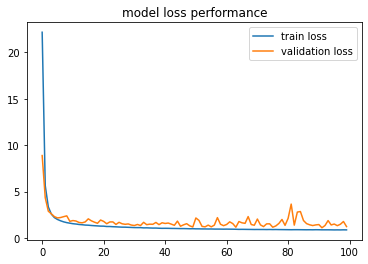

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss performance')
plt.legend(['train loss', 'validation loss'])
plt.show()

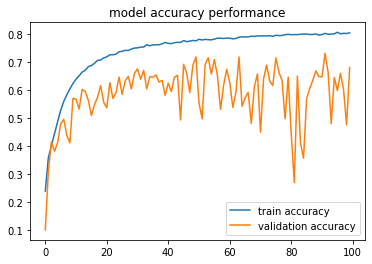

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy performance')
plt.legend(['train accuracy', 'validation accuracy'])
plt.show()

In [13]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 5ms/step - loss: 1.2454 - accuracy: 0.6807


[1.2454005479812622, 0.6807000041007996]